In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast
import warnings; warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import torch
from torch import nn

In [2]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [3]:
path = 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
sampling_rate=100

In [4]:
# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
all_samples = Y.shape[0]
print("Total Number of Samples", all_samples)

Total Number of Samples 21837


In [5]:
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [6]:
# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)
X.shape

(21837, 1000, 12)

In [7]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

In [8]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [9]:
# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [10]:
Y.diagnostic_superclass

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 21837, dtype: object

In [11]:
# Split data into train and test
test_fold = 10

# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass

In [12]:
#X_train[69]
(y_train)

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 19634, dtype: object

In [13]:
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass
print(X_test.shape)
y_test

(2203, 1000, 12)


ecg_id
9        [NORM]
38       [NORM]
40       [NORM]
57       [NORM]
59       [NORM]
          ...  
21809    [NORM]
21812      [CD]
21818    [NORM]
21819      [CD]
21826      [MI]
Name: diagnostic_superclass, Length: 2203, dtype: object

In [14]:
torch.manual_seed(111)

In [15]:
train_data_length = 1024

<AxesSubplot:>

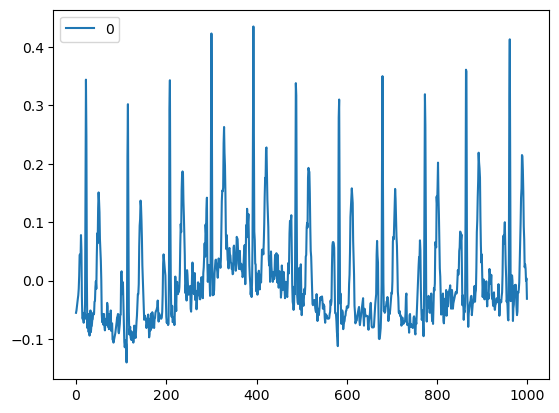

In [16]:
# let's pick an arbitrary signal and it's information from Y index_column
ecg_record = 0    
Lead_I_data = X[ecg_record][:,1] # Index of Lead. It is available in meta_data information
#ecg_info = Y.iloc[ecg_record]
pd.DataFrame(Lead_I_data).plot()
#Lead_I_data

In [17]:
#plot as sub plots for all the 12 leads
#leads = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
#fig, axes = plt.subplots(12,1, figsize =(12,20))

#for i, ax in enumerate(axes.flatten()):
#    r= X[ecg_record][:,i]
#    ax.plot(r,color=plt.cm.Paired(i/20.),label = leads[i])
#    axes[i].set_ylabel('Amplitude')
#    axes[i].set_xlabel('Sample Points')
#   axes[i].legend()
#plt.xlabel("Sample Points")
#plt.show()

In [18]:
#Logic to fetch 1024 Normal ECG records Lead_I data from the dataset

cls_normal = ['NORM']
temp = 0
#X_trainsample = X[np.where(Y.iloc[0].diagnostic_superclass == cls_normal)]
#n=np.where(Y.iloc[0].diagnostic_superclass == cls_normal)
#print(X[3])
s = (1000,12)
count = 0
#X_train_normal = np.empty((1024,1000,12))
Lead_I_train_data = np.empty((1024,1000,))
#step = np.zeros(s)
for k in range(all_samples):
    if (k in y_train.index.values) :
        if (y_train[k] == cls_normal):
            #step = (X[k])
            if(count == 1024):
                break
            #X_train_normal[count]=step
            Lead_I_train_data[count] = X[k][:,1]
            count = count+1
print(Lead_I_train_data.shape)
#pd.DataFrame(Lead_I_train_data).plot()

(1024, 1000)


In [19]:
train_data = Lead_I_train_data
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]
#train_set

In [20]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [21]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
             nn.Linear(1000, 256),
             nn.ReLU(),
             nn.Dropout(0.3),
             nn.Linear(256, 128),
             nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [22]:
discriminator = Discriminator()

In [23]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1000, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1000),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

In [24]:
lr = 0.001
num_epochs = 1000
loss_function = nn.BCELoss()

In [25]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [26]:
# Check to train with a GPU
#torch.cuda.is_available()

Epoch: 0 Loss D.: 0.24807530641555786 Loss G.: 3.26653790473938 
Epoch: 50 Loss D.: 0.23618684709072113 Loss G.: 7.581045150756836 
Epoch: 100 Loss D.: 0.11839526146650314 Loss G.: 6.702920913696289 
Epoch: 150 Loss D.: 0.03124181553721428 Loss G.: 9.855133056640625 
Epoch: 200 Loss D.: 0.126852884888649 Loss G.: 10.501045227050781 
Epoch: 250 Loss D.: 0.024166574701666832 Loss G.: 10.748523712158203 
Epoch: 300 Loss D.: 0.016280142590403557 Loss G.: 8.32476806640625 
Epoch: 350 Loss D.: 0.12273438274860382 Loss G.: 7.420612335205078 
Epoch: 400 Loss D.: 0.09638197720050812 Loss G.: 9.004037857055664 
Epoch: 450 Loss D.: 0.01900702714920044 Loss G.: 8.237754821777344 
Epoch: 500 Loss D.: 0.10787580162286758 Loss G.: 10.124799728393555 
Epoch: 550 Loss D.: 0.3205200135707855 Loss G.: 9.252033233642578 
Epoch: 600 Loss D.: 0.004327511880546808 Loss G.: 8.090669631958008 
Epoch: 650 Loss D.: 0.04449484124779701 Loss G.: 7.262203693389893 
Epoch: 700 Loss D.: 0.006276272237300873 Loss G.: 

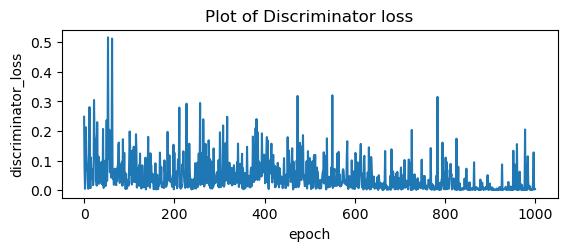

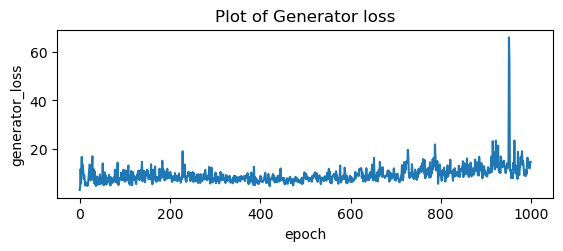

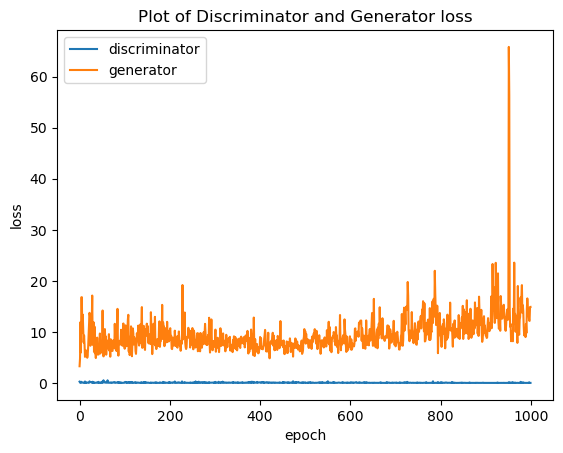

In [27]:
loss_disc = []
loss_gen = []
epochs= []
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 1000))
        generated_samples = generator(latent_space_samples)   
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )
        
        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples.float())
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 1000))
        
        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()
        
        if n == batch_size - 1:
            epochs.append(epoch)
            loss_disc.append(loss_discriminator.item() )
            loss_gen.append(loss_generator.item() )
        
        # Show loss
        if epoch % 50 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator} Loss G.: {loss_generator} ")
            #print(f"Epoch: {epoch} Loss G.: {loss_generator}")
plt.subplot(2, 1, 1)
#plot the discriminator loss
plt.plot(epochs,loss_disc)
plt.title('Plot of Discriminator loss')
plt.xlabel('epoch')
plt.ylabel('discriminator_loss')
plt.show()
#plot the generator loss
plt.subplot(2, 1, 2)
plt.plot(epochs,loss_gen)
plt.title('Plot of Generator loss')
plt.xlabel('epoch')
plt.ylabel('generator_loss')
plt.show()


#plot the discriminator loss
plt.plot(epochs,loss_disc,label = 'discriminator')
#plot the generator loss
plt.plot(epochs,loss_gen,label = 'generator')
plt.title('Plot of Discriminator and Generator loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="upper left")
plt.show()

In [31]:
generated_count = 20
latent_space_samples = torch.randn(generated_count, 1000)
generated_samples = generator(latent_space_samples)
print(generated_samples)

tensor([[ 0.0143,  0.0334,  0.0012,  ..., -0.0960,  0.0808,  0.1860],
        [ 0.0143,  0.0334,  0.0012,  ..., -0.0960,  0.0808,  0.1860],
        [ 0.0143,  0.0334,  0.0012,  ..., -0.0960,  0.0808,  0.1860],
        ...,
        [ 0.1451,  0.1759,  0.1364,  ..., -0.0305,  0.1348,  0.3005],
        [ 0.0143,  0.0334,  0.0012,  ..., -0.0960,  0.0808,  0.1860],
        [ 0.0143,  0.0334,  0.0012,  ..., -0.0960,  0.0808,  0.1860]],
       grad_fn=<AddmmBackward0>)


In [32]:
for i in range(0, generated_count):
    if(i != 0):
        print ("Generated Signal with index 0 and index " ,i, "are Same ? -",
               torch.equal(generated_samples[0], generated_samples[i]))

Generated Signal with index 0 and index  1 are Same ? - True
Generated Signal with index 0 and index  2 are Same ? - True
Generated Signal with index 0 and index  3 are Same ? - False
Generated Signal with index 0 and index  4 are Same ? - True
Generated Signal with index 0 and index  5 are Same ? - True
Generated Signal with index 0 and index  6 are Same ? - True
Generated Signal with index 0 and index  7 are Same ? - True
Generated Signal with index 0 and index  8 are Same ? - True
Generated Signal with index 0 and index  9 are Same ? - False
Generated Signal with index 0 and index  10 are Same ? - True
Generated Signal with index 0 and index  11 are Same ? - True
Generated Signal with index 0 and index  12 are Same ? - True
Generated Signal with index 0 and index  13 are Same ? - False
Generated Signal with index 0 and index  14 are Same ? - True
Generated Signal with index 0 and index  15 are Same ? - True
Generated Signal with index 0 and index  16 are Same ? - True
Generated Sign

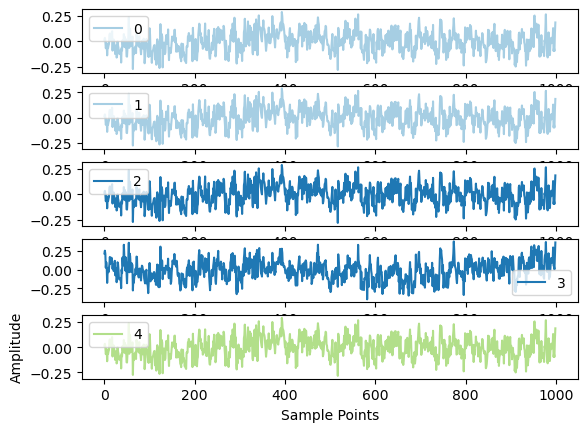

In [37]:
#define subplot layout
fig, axes = plt.subplots(nrows=5, ncols=1)
for i, ax in enumerate(axes.flatten()):
    r= generated_samples.detach().numpy()[i]
    ax.plot(r,color=plt.cm.Paired(i/20.),label = i)
    #axes[i].set_ylabel('Amplitude')
    #axes[i].set_xlabel('Sample Points')
    axes[i].legend()
plt.xlabel("Sample Points")
plt.ylabel("Amplitude")
plt.show()